Generate the relevant vizualizations:

* Basic level: NEXT vs Salmon vs random

Why does Salmon do so much better?

* Embedding? Perform the same search use NEXT/Salmon embedding code.
* Searches? Use same backend, different search params.
    * → also show Salmon has effective engineering
    
Why is Salmon's search so much better?

* How does round robin affect different search lengths?
* How does top-k affect long search?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from viz import lineplot
save_kwargs = dict(dpi=300, bbox_inches="tight", transparent=True)

In [4]:
nm = "CKL"
d = 2

ACC_YLIM = (0.80, 0.835)
ANS_XLIM = (0, 25_000)

In [6]:
def _get_n_search(x: str) -> int:
    for j in ["-1_responses.csv.zip", "salmon/io/2021-05-26-search/TSTE-"]:
        assert j in x
        x = x.replace(j, "")
    k, v = x.split("=")
    assert k == "n_search"
    return int(v)
def _get_meta(x, key="n_search"):
    for j in  ["salmon/io/2021-07-01-arr-search/ARR-", "-1_responses.csv.zip"]:
        x = x.replace(j, "")
    n_search, n_top = x.split("-")
    assert "n_search=" in n_search and "n_top=" in n_top
    if key == "n_search":
        k_v = n_search.split("=")
    elif key == "n_top":
        k_v = n_top.split("=")
    else:
        raise ValueError(f"key={key} not recnogized")
    return int(k_v[1])

df = pd.read_csv("_viz_data.csv")
df["error"] = 1 - df["accuracy"]

print(len(df))
idx = (df.meta__noise_model == nm) & (df.meta__d == d)
df = df[idx].copy()
random_priority = df.meta__priority.isnull()
df = df[random_priority]
print(df.meta__meta__fname.unique())
print(len(df))

idx = df.meta__sampling == "random"
random = df[idx].copy()
active = df[~idx].copy()
NEXT = df[df.meta__sampling == "next"].copy()


fnames = df.meta__meta__fname.copy()
fnames[fnames.isnull()] = "random"
greedy = df[fnames.apply(lambda x: "/TSTE-" in x)].copy()
assert all(greedy.meta__meta__fname.apply(lambda x: "2021-05-26" in x))

greedy["meta__n_search"] = greedy["meta__meta__fname"].apply(_get_n_search)

arr = df[fnames.apply(lambda x: "/ARR-" in x)].copy()
assert all(arr.meta__meta__fname.apply(lambda x: "2021-07-01-arr-search" in x))

for key in ["n_search", "n_top"]:
    arr[f"meta__{key}"] = arr.meta__meta__fname.apply(_get_meta, key=key)

assert len(random) and len(NEXT) and len(greedy) and len(arr)
df.columns

464
['salmon/io/2021-05-26-search/TSTE-n_search=100-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=30000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=1000-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=1000-n_top=1-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=10000-n_top=1-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=100000-n_top=1-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=10000-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=3000-n_top=1-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=30000-n_top=1-1_responses.csv.zip'
 'salmon/io/2021-07-01-arr-search/ARR-n_search=352440-n_top=1-1_responses.csv.zip'
 'salmon/io/

Index(['Unnamed: 0', 'accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25',

# Search length

Getting different samplers.

In [7]:
def _fmt(axs):
    ax = axs[0]
    ax.set_ylim(0.15, 0.24)
    ax.set_title("Test error")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x * 100:0.0f}%"))
    
    ax = axs[1]
    ax.set_ylim(0, 9)
    ax.set_ylabel("Avg. distance\n(# of neighbors)")
    ax.set_title("Distance to true\nnearest neighbor")
    for ax in axs:
        ax.grid(alpha=0.5)
        ax.set_xlim(0, 7200)
#         ax.set_xlim(0, None)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x / 1000)))
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        ax.set_xlabel("Num. responses / 1000")
    return axs

**(decent for low search; bad for high search)**

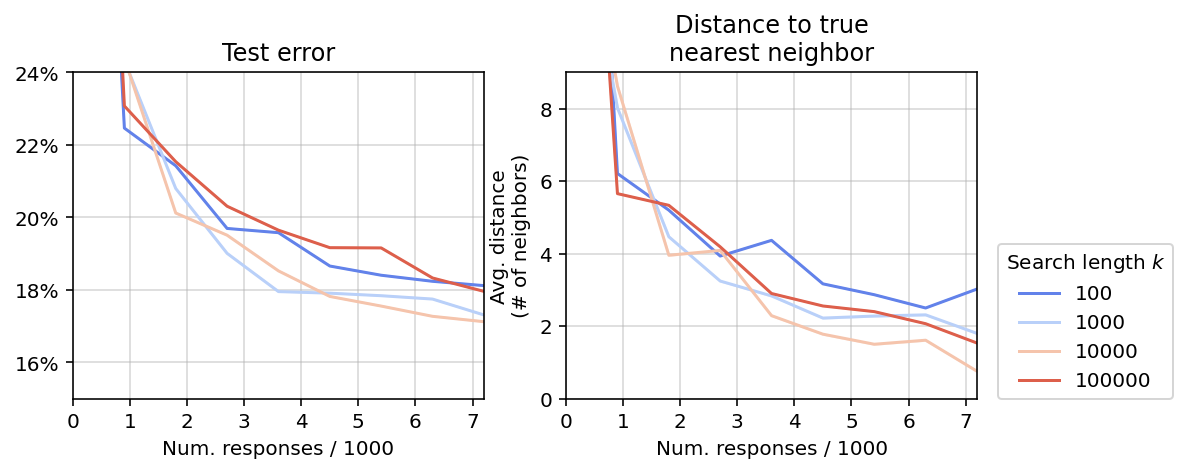

In [9]:

from viz import lineplot

hue = "meta__n_search"
hue_order = list(sorted(greedy[hue].unique()))
# n_searches = [3 * 10**i for i in [1, 2, 3, 4, 5]]
n_searches = [1 * 10**i for i in [1, 2, 3, 4, 5]]
# n_searches += [30, 300_000]
static = dict(
    x="meta__len_X_train",
    hue=hue,
    hue_order=hue_order,
    palette="coolwarm",
    data=greedy[greedy.meta__n_search.isin(n_searches)],
    ci=1.0,
)

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * 1.35 * w, w))
ax = lineplot(
    y="error",
    **static,
    ax=axs[0],
)
ax.set_ylim(0.15, 0.25)
ax.legend_.remove()

ax = lineplot(
    y="nn_diff_mean",
    **static,
    ax=axs[1],
)
ax.set_ylim(0, 9)
ax.legend(loc=(1.05, 0))
ax.legend_.set_title("Search length $k$")

axs = _fmt(axs)
fig.savefig("figures/greedy-search-length.png", **save_kwargs)

## ARR
**(this should look better)**

Int64Index([30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000], dtype='int64', name='meta__n_search')


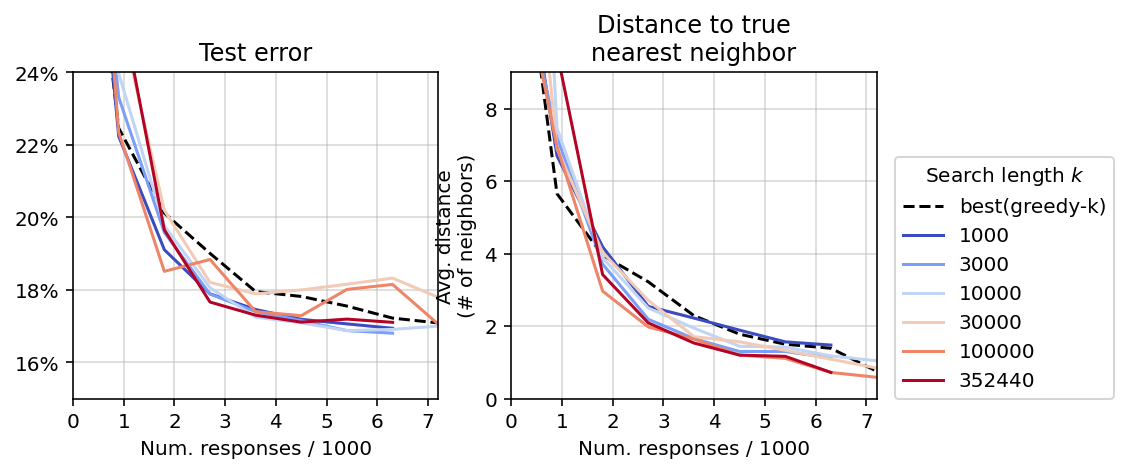

In [12]:

from viz import lineplot

idx = arr.meta__n_top == 1
arr.meta__n_top.unique()
n_searches = [1000, 3000, 10_000, 30_000, 100_000, 90 * 89 * 88 // 2]
# n_searches = [3000, 10_000, 30_000, 100_000, 90 * 89 * 88 // 2]
static = dict(
    x="meta__len_X_train",
    hue="meta__n_search",
#     data=arr[(arr.meta__n_top == 1)],
    data=arr[(arr.meta__n_top == 1) & (arr.meta__n_search.isin(n_searches))],
#     data=arr[(arr.meta__n_top == 1) & (arr.meta__n_search.isin([1000, 10_000, 30_000, 100_000, 90 * 89 * 88 // 2]))],
    ci=1.0,
    palette="coolwarm",
)

best_accs = greedy.pivot(
    columns="meta__len_X_train",
    values="accuracy",
    index="meta__n_search",
)
best_nns = greedy.pivot(
    columns="meta__len_X_train",
    values="nn_diff_mean",
    index="meta__n_search",
).min()
print(best_accs.index)
best_accs = best_accs.max()
best_errors = 1 - best_accs

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * 1.2 * w, w))
axs[0].plot(best_errors.index, best_errors.values, "--", color="black", label="best(greedy-k)")
ax = lineplot(
    y="error",
    **static,
    ax=axs[0],
)
ax.set_ylim(0.15, 0.25)
ax.legend_.remove()

axs[1].plot(best_nns.index, best_nns.values, "--", color="black", label="best(greedy-k)")
ax = lineplot(
    y="nn_diff_mean",
    **static,
    ax=axs[1],
)
ax.legend(loc=(1.05, 0))
ax.legend_.set_title("Search length $k$")

axs = _fmt(axs)
fig.savefig("figures/rr-search-length.png", **save_kwargs)

In [13]:
greedy.columns

Index(['Unnamed: 0', 'accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25',

# Random head selection

In [14]:
arr.meta__n_top.unique()

array([   1,   10,  100, 1000,    3,   30,  300])

In [15]:
w

3

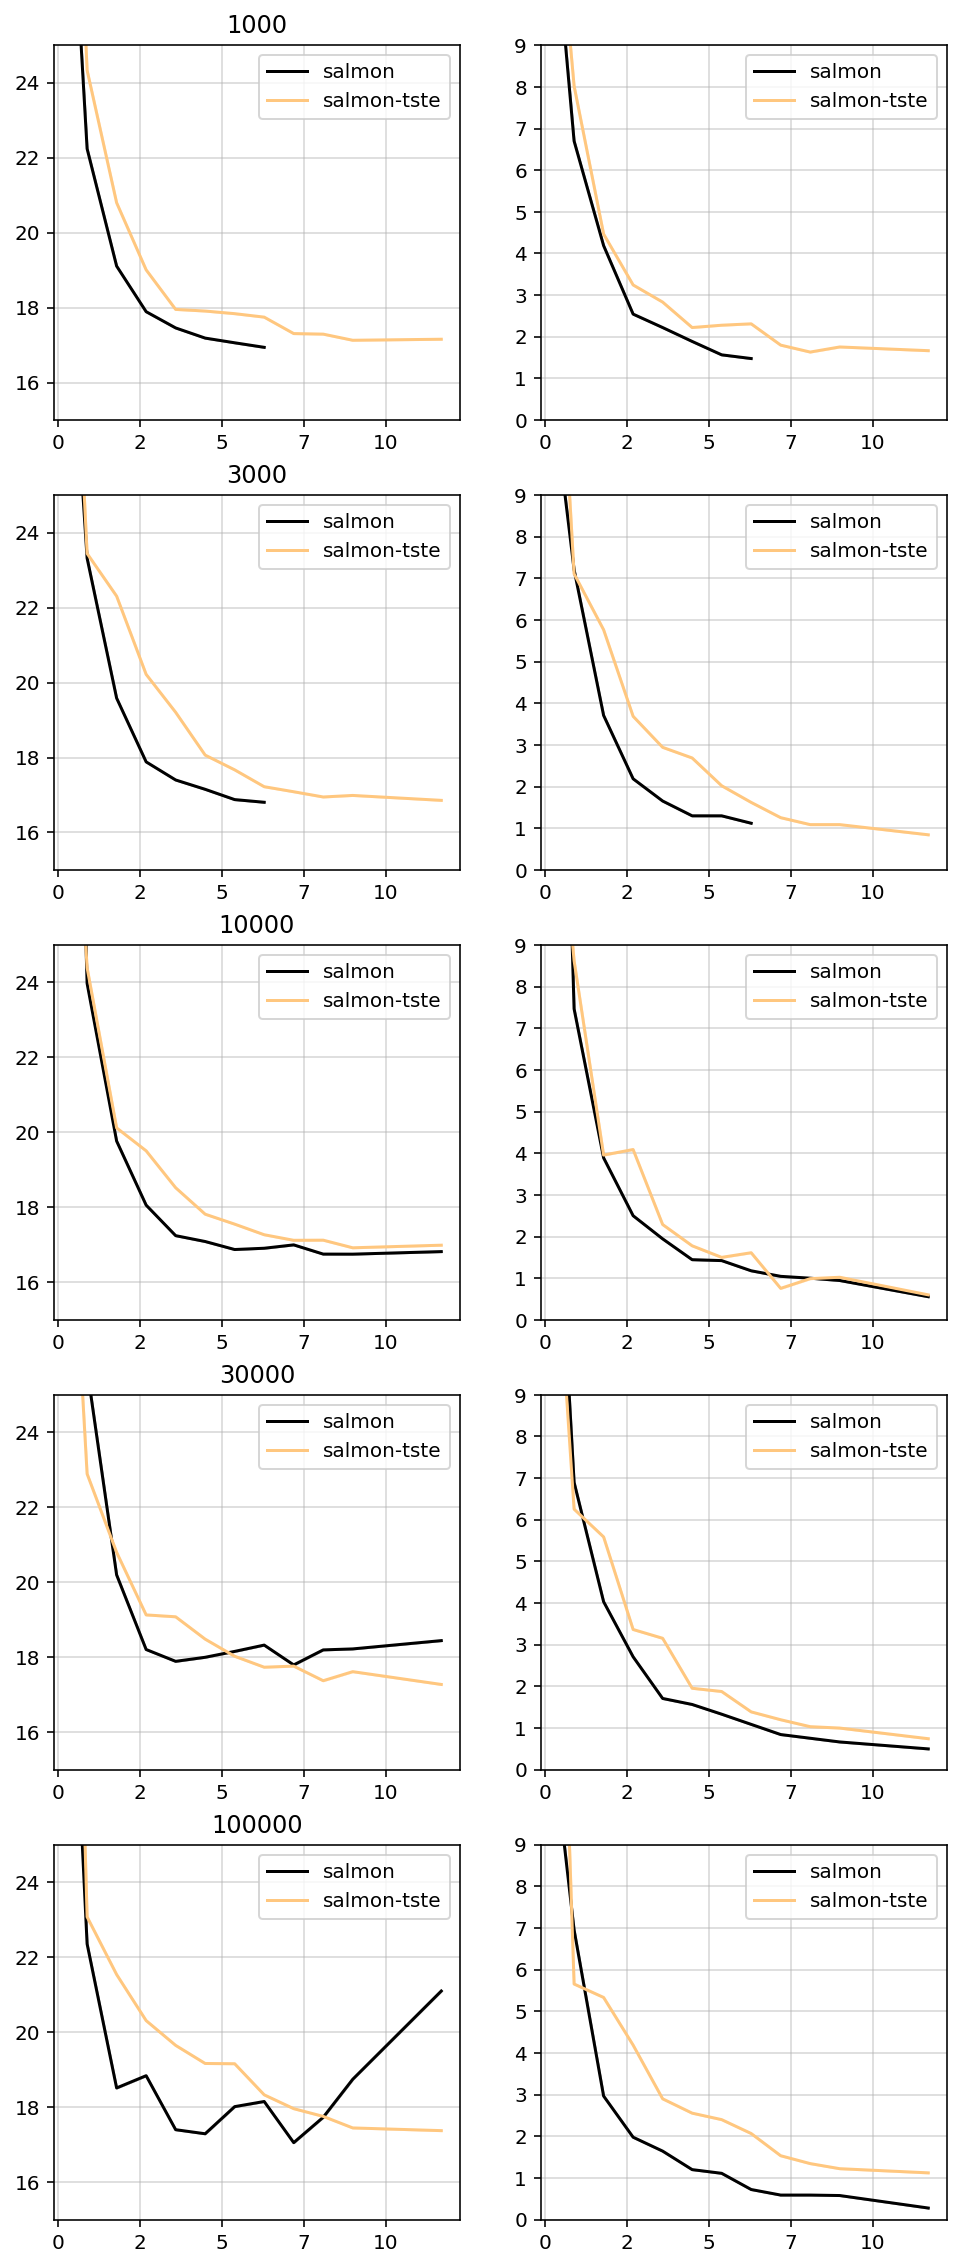

In [16]:
n_searches = set(greedy.meta__n_search.unique()).intersection(arr.meta__n_search.unique())
n_searches = list(sorted(list(n_searches)))

w = 4
fig, axs = plt.subplots(nrows=len(n_searches), ncols=2, figsize=(2 * w, w * len(n_searches)))

for n_search, row in zip(n_searches, axs):
    show1 = greedy[greedy.meta__n_search == n_search]
    show2 = arr[(arr.meta__n_search == n_search) & (arr.meta__n_top == 1)]
    show = pd.concat((show1, show2))
    static = dict(
        x="meta__len_X_train",
        data=show,
        hue="meta__sampling",
        ci=0.5,
    )
    _ = row[0].set_title(n_search)
    ax = lineplot(y="error", ax=row[0], **static)
    _ = ax.set_ylim(0.15, 0.25)
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(100 * x)}"))
    ax = lineplot(y="nn_diff_mean", ax=row[1], **static)
    _ = ax.set_ylim(0, 1 * 9)
    for ax in row:
        _ = ax.grid(alpha=0.5)
        _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x // 1000)))
    
    

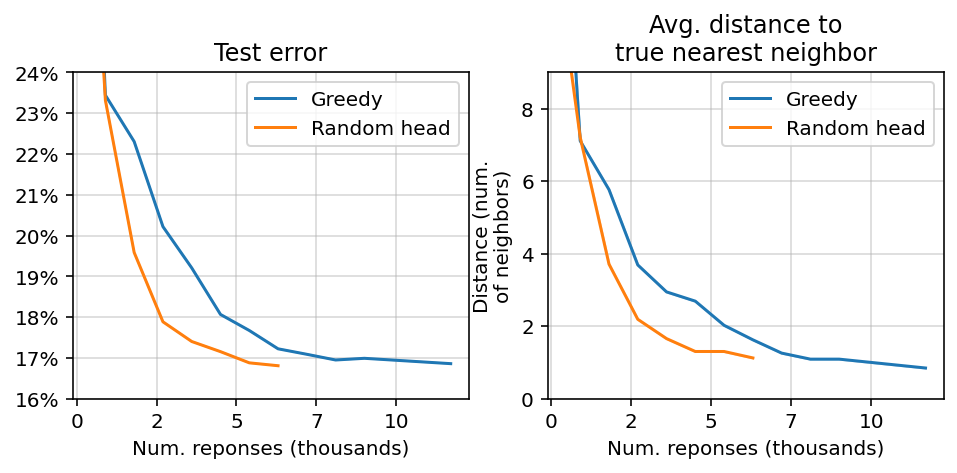

In [17]:
n_searches = set(greedy.meta__n_search.unique()).intersection(arr.meta__n_search.unique())
n_searches = list(sorted(list(n_searches)))

w = 3
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 1.3 * w, w))

n_search = 3_000
idx1 = greedy.meta__n_search == n_search
assert idx1.sum() > 0
show1 = greedy[idx1]
idx2 = (arr.meta__n_search == n_search) & (arr.meta__n_top == 1)
assert idx2.sum() > 0
show2 = arr[idx2]
show = pd.concat((show1, show2))

hue = "Sampling strategy"
show.loc[show.meta__sampling == "salmon-tste", hue] = "Greedy"
show.loc[show.meta__sampling == "salmon", hue] = "Random head"
static = dict(
    x="meta__len_X_train",
    data=show,
    hue=hue,
    hue_order=["Greedy", "Random head"],
#     palette="tab10",
    palette=["C0", "C1"],
    ci=0.5,
)
_ = axs[0].set_title("Test error")
ax = lineplot(y="error", ax=axs[0], **static)
_ = ax.set_ylim(0.16, 0.24)
ax = lineplot(y="nn_diff_mean", ax=axs[1], **static)
_ = ax.set_title("Avg. distance to\ntrue nearest neighbor")
_ = ax.set_ylabel("Distance (num.\nof neighbors)")
_ = ax.set_ylim(0, 1 * 9)

axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
axs[1].set_ylim(0, 9)
for ax in axs:
    ax.grid(alpha=0.5)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x // 1000)))
    ax.set_xlabel("Num. reponses (thousands)")

fig.savefig("figures/random-head-selection.png", **save_kwargs)
    

# Number of top items

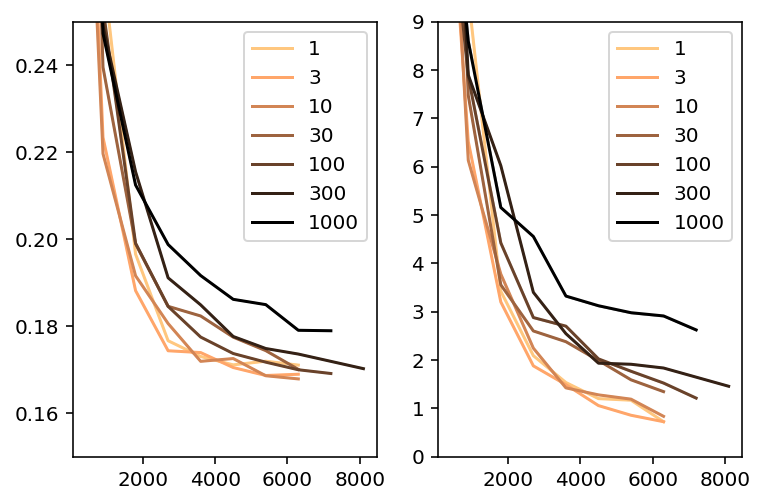

In [18]:
idx = arr.meta__n_search== int(90 * 89 * 88 * 0.5)
# idx &= arr.meta__n_top.isin([1, 3, 10, 100, 1000])

static = dict(
    x="meta__len_X_train",
    data=arr[idx],
    hue="meta__n_top",
    palette="copper_r",
    ci=0.5,
)

fig, axs = plt.subplots(ncols=2)
ax = lineplot(y="error", ax=axs[0], **static)
_ = ax.set_ylim(0.15, 0.25)
ax = lineplot(y="nn_diff_mean", ax=axs[1], **static)
_ = ax.set_ylim(0, 1 * 9)

# axs[0].set_xlim(3500, 3700)

# arr[idx]

In [12]:
arr[idx].meta__n_search.unique()

array([352440])